In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

import datetime
import pickle
import itertools
import random

import librosa
import librosa.display
import librosa as lr
from librosa import feature

from maad import sound
from time import time
from time import sleep
from tqdm import tqdm

from CNN_Network import network
from utils import plot_confusion_matrix, plot_listen_examples, plot_nn_history

from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


from keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras import backend
from tensorflow.keras.layers import Dense, Dropout, Flatten, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

sns.set_theme()
plt.rcParams["figure.figsize"] = (17, 5)

Using TensorFlow backend.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0001:00:00.0, compute capability: 3.7



# Classifier of anuraset 

Goal: detect in sound each species

Aproach: use binary classifiers for each species

## Extract segments, preprocessing and augment all training files

- Should we extract segments? In our case no, there is a fixed lenght!
- Should we preprocess? Not shure, check steps
- Should we augment the data? Not shure, in the creation of the dataset there is an augmentation step. 
- Experiment: apply with and without augmentation 
- In some folder we should split training and testing! 

In [3]:
audio_directory = 'Raw_Data/Train/'
timestamp_directory = 'Call_Labels/'
save_location = 'Pickled_Data/'
augment_directory = 'Augmented_Data/'
augment_image_directory = 'Augmented_Image_Data/'
training_file = 'Training_Files.txt'

sample_rate = 4800
number_seconds_to_extract = 10
seed = 42
number_iterations = 1
augmentation_probability = 1.0
augmentation_amount_noise = 2
augmentation_amount_gibbon = 10

In [4]:
#%% Set variables
path_audio = '/home/azureuser/cloudfiles/code/Users/jscanass/anuraset/BuildDataset/datasetv2-multiclass_1/audio'
path_annotations = '/home/azureuser/cloudfiles/code/Users/jscanass/anuraset/BuildDataset/datasetv2-multiclass_1/df_train_test_files.csv'
path_results = '/home/azureuser/cloudfiles/code/Users/jscanass/chorus_experiments/models/sklearn_baseline/results'
target_fs = 22050  # set target sampling rate for audio

In [5]:
#%% Load annotations
df = pd.read_csv(path_annotations)
print('Size:',df.shape)
df = df[df['site']=='INCT20955']
df = df[['sample_name', 'fname', 'min_t', 'max_t', 
        'label','classID','fold', 'subset','quality']]
print(df['label'].value_counts())
print('Size:',df.shape)

df.head()

Size: (13874, 31)
ABSENCE     3023
BOAFAB_M    1566
PHYCUV_F     820
BOAFAB_F     467
PHYCUV_M     170
Name: label, dtype: int64
Size: (6046, 9)


,sample_name,fname,min_t,max_t,label,classID,fold,subset,quality
0,SAMPLE_00000_INCT20955_BOAFAB_F_FOLD_4.wav,INCT20955_20190930_210000,14,17,BOAFAB_F,8,4,train,F
1,SAMPLE_00001_INCT20955_BOAFAB_F_FOLD_4.wav,INCT20955_20190930_210000,20,23,BOAFAB_F,8,4,train,F
2,SAMPLE_00002_INCT20955_BOAFAB_F_FOLD_4.wav,INCT20955_20190930_210000,25,28,BOAFAB_F,8,4,train,F
3,SAMPLE_00003_INCT20955_BOAFAB_F_FOLD_4.wav,INCT20955_20190930_210000,30,33,BOAFAB_F,8,4,train,F
4,SAMPLE_00004_INCT20955_BOAFAB_F_FOLD_4.wav,INCT20955_20190930_210000,33,36,BOAFAB_F,8,4,train,F


In [6]:
X_img = []  

n_fft = 1024
hop_length = 256 
n_mels = 128
f_min = 50
f_max = 4000
    
for idx_row, row in tqdm(df.iterrows()):
    t0_features = time()
    full_path_audio = os.path.join(path_audio, row['sample_name'])
    s, fs = sound.load(full_path_audio)
    S = librosa.feature.melspectrogram(y=s,sr=fs, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=1.0, fmin = f_min, fmax=f_max)
    X_img.append(S)

6046it [08:30, 11.85it/s]


In [7]:
X_img = np.asarray(X_img)
X_img = np.reshape(X_img, (X_img.shape[0],X_img.shape[1],X_img.shape[2],1))

In [8]:
X_img.shape

(6046, 128, 259, 1)

In [9]:
X_img[0].shape
#(128, 259)

(128, 259, 1)

# Binary Classification:

In [11]:
def get_dataset(df, name, F_class=True, label_name = 'BOAFAB', verbose=False):
    
    # Version 1: Umbalanced with BOAFAB_F 
    # Version 2: Umbalanced without BOAFAB_F 
    # Version 3: Random balanced with BOAFAB_F
    # Version 4: Random balanced without BOAFAB_F
    
    df['classID'] = df['label'].apply(lambda x: 1 if label_name in x else 0)
    df_test = df[df['subset']=='test']
    if not F_class:
        df_test = df_test[df_test['quality']!='F']
    df_train = df[df['subset']=='train'] 
    if (name == 'version2') or (name == 'version4'):
        df_train = df_train[(df_train['label']!='BOAFAB_F')]
    if (name == 'version4') or (name == 'version3'): 
        n_to_balance = df_train[df_train['classID']==1].shape[0]
        df_train_absence = df_train[df_train['classID']==0].sample(n_to_balance)
        df_train = pd.concat([df_train[df_train['classID']==1],df_train_absence])
    df_dataset = pd.concat([df_train, df_test])
    if verbose:
        display(pd.crosstab(df_dataset['classID'], df_dataset['label'], margins=True))
        display(pd.crosstab(df_dataset['classID'], df_dataset['subset'], margins=True))
        display(pd.crosstab(df_dataset['label'], df_dataset['subset'], margins=True))
    return df_dataset

In [12]:
def create_seed():
    return random.randint(1, 1000000)

In [13]:
feature = 'mfcc'
model_type = 'CNN'
epochs = 10 #50
batch_size = 8 #use 128
save = True
df_dataset = df.copy() 

In [14]:
df_dataset['classID'].value_counts()

1     3023
2     1566
5      820
8      467
11     170
Name: classID, dtype: int64

In [15]:
for dataset_name in ['version1','version2','version3','version4']:
    get_dataset(df_dataset, name=dataset_name,verbose=True)

label,ABSENCE,BOAFAB_F,BOAFAB_M,PHYCUV_F,PHYCUV_M,All
classID,,,,,,
0,3023,0,0,820,170,4013
1,0,467,1566,0,0,2033
All,3023,467,1566,820,170,6046


subset,test,train,All
classID,,,
0,672,3341,4013
1,343,1690,2033
All,1015,5031,6046


subset,test,train,All
label,,,
ABSENCE,505,2518,3023
BOAFAB_F,81,386,467
BOAFAB_M,262,1304,1566
PHYCUV_F,139,681,820
PHYCUV_M,28,142,170
All,1015,5031,6046


label,ABSENCE,BOAFAB_F,BOAFAB_M,PHYCUV_F,PHYCUV_M,All
classID,,,,,,
0,3023,0,0,820,170,4013
1,0,81,1566,0,0,1647
All,3023,81,1566,820,170,5660


subset,test,train,All
classID,,,
0,672,3341,4013
1,343,1304,1647
All,1015,4645,5660


subset,test,train,All
label,,,
ABSENCE,505,2518,3023
BOAFAB_F,81,0,81
BOAFAB_M,262,1304,1566
PHYCUV_F,139,681,820
PHYCUV_M,28,142,170
All,1015,4645,5660


label,ABSENCE,BOAFAB_F,BOAFAB_M,PHYCUV_F,PHYCUV_M,All
classID,,,,,,
0,1812,0,0,459,91,2362
1,0,467,1566,0,0,2033
All,1812,467,1566,459,91,4395


subset,test,train,All
classID,,,
0,672,1690,2362
1,343,1690,2033
All,1015,3380,4395


subset,test,train,All
label,,,
ABSENCE,505,1307,1812
BOAFAB_F,81,386,467
BOAFAB_M,262,1304,1566
PHYCUV_F,139,320,459
PHYCUV_M,28,63,91
All,1015,3380,4395


label,ABSENCE,BOAFAB_F,BOAFAB_M,PHYCUV_F,PHYCUV_M,All
classID,,,,,,
0,1474,0,0,412,90,1976
1,0,81,1566,0,0,1647
All,1474,81,1566,412,90,3623


subset,test,train,All
classID,,,
0,672,1304,1976
1,343,1304,1647
All,1015,2608,3623


subset,test,train,All
label,,,
ABSENCE,505,969,1474
BOAFAB_F,81,0,81
BOAFAB_M,262,1304,1566
PHYCUV_F,139,273,412
PHYCUV_M,28,62,90
All,1015,2608,3623


 ---------------- Binary classification for  version1  ----------------
X_train: (5031, 128, 259, 1)
Y_train: (5031, 2)

X_val: (1015, 128, 259, 1)
Y_val: (1015, 2)
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 113, 244, 8)       2056      
_________________________________________________________________
dropout_6 (Dropout)          (None, 113, 244, 8)       0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 61, 8)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 13, 46, 8)         16392     
_________________________________________________________________
dropout_7 (Dropout)          (None, 13, 46, 8)         0         
_________________________________________________________________
max_pooling2d_5 (MaxP

<Figure size 1224x360 with 0 Axes>

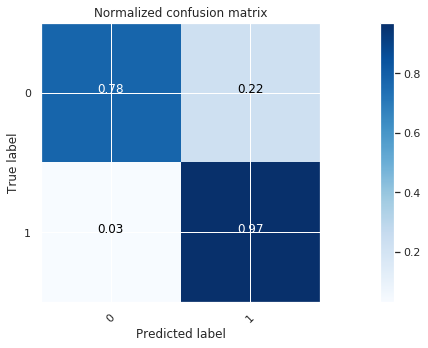

              precision    recall  f1-score   support

           0       0.98      0.78      0.87       672
           1       0.69      0.97      0.81       343

   micro avg       0.84      0.84      0.84      1015
   macro avg       0.84      0.87      0.84      1015
weighted avg       0.88      0.84      0.85      1015

Results saved to:
/home/azureuser/cloudfiles/code/Users/jscanass/chorus_experiments/models/sklearn_baseline/results/634439_performance.txt
-------------------
 ---------------- Binary classification for  version2  ----------------
X_train: (4645, 128, 259, 1)
Y_train: (4645, 2)

X_val: (1015, 128, 259, 1)
Y_val: (1015, 2)
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 113, 244, 8)       2056      
_________________________________________________________________
dropout_9 (Dropout)          (None, 113, 244, 8)       0       

<Figure size 1224x360 with 0 Axes>

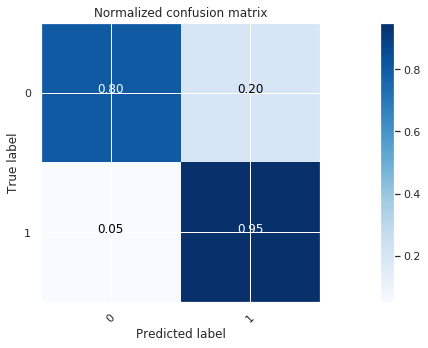

              precision    recall  f1-score   support

           0       0.97      0.80      0.88       672
           1       0.71      0.95      0.81       343

   micro avg       0.85      0.85      0.85      1015
   macro avg       0.84      0.88      0.85      1015
weighted avg       0.88      0.85      0.86      1015

Results saved to:
/home/azureuser/cloudfiles/code/Users/jscanass/chorus_experiments/models/sklearn_baseline/results/117769_performance.txt
-------------------
 ---------------- Binary classification for  version3  ----------------
X_train: (3380, 128, 259, 1)
Y_train: (3380, 2)

X_val: (1015, 128, 259, 1)
Y_val: (1015, 2)
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 113, 244, 8)       2056      
_________________________________________________________________
dropout_12 (Dropout)         (None, 113, 244, 8)       0       

<Figure size 1224x360 with 0 Axes>

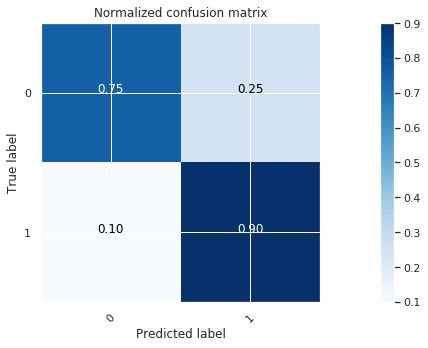

              precision    recall  f1-score   support

           0       0.94      0.75      0.83       672
           1       0.65      0.90      0.76       343

   micro avg       0.80      0.80      0.80      1015
   macro avg       0.79      0.83      0.80      1015
weighted avg       0.84      0.80      0.81      1015

Results saved to:
/home/azureuser/cloudfiles/code/Users/jscanass/chorus_experiments/models/sklearn_baseline/results/982020_performance.txt
-------------------
 ---------------- Binary classification for  version4  ----------------
X_train: (2608, 128, 259, 1)
Y_train: (2608, 2)

X_val: (1015, 128, 259, 1)
Y_val: (1015, 2)
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 113, 244, 8)       2056      
_________________________________________________________________
dropout_15 (Dropout)         (None, 113, 244, 8)       0       

<Figure size 1224x360 with 0 Axes>

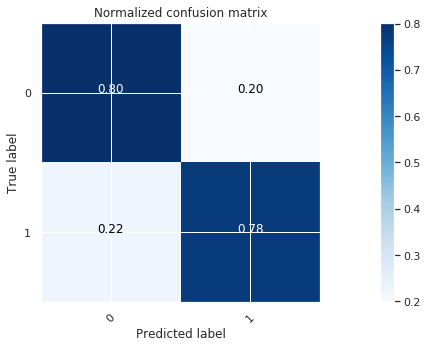

              precision    recall  f1-score   support

           0       0.88      0.80      0.84       672
           1       0.67      0.78      0.72       343

   micro avg       0.79      0.79      0.79      1015
   macro avg       0.77      0.79      0.78      1015
weighted avg       0.80      0.79      0.80      1015

Results saved to:
/home/azureuser/cloudfiles/code/Users/jscanass/chorus_experiments/models/sklearn_baseline/results/18200_performance.txt
-------------------


In [18]:
all_results = []
label_name = 'BOAFAB'
for dataset_name in ['version1','version2','version3','version4']:
 
    #for feature in []:#'shp' ,'all']:
        #%% Split development and test date
    df = get_dataset(df_dataset, name=dataset_name)
    df_train = df[df['subset']=='train']
    df_test = df[df['subset']=='test']
    dataset_size = df.shape[0]

    print(' ---------------- Binary classification for ', dataset_name, ' ----------------')
    seed = create_seed()

    X_train = np.array([X_img[i] for i in range(len(X_img)) if i in df_train.index])
    X_val = np.array([X_img[i] for i in range(len(X_img)) if i in df_test.index])
    Y_train = df_train['classID']
    Y_val = df_test['classID']
    Y_val = to_categorical(Y_val)
    Y_train = to_categorical(Y_train)

    # Check shape
    print ('X_train:',X_train.shape)
    print ('Y_train:',Y_train.shape)
    print ()
    print ('X_val:',X_val.shape)
    print ('Y_val:',Y_val.shape)

    # Call backs to save weights
    filepath= "experiments/weights_{}.hdf5".format(seed)
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy',verbose=1, save_best_only=True, mode='max')
    #callbacks_list = [checkpoint]

    model = network()
    model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
    print(model.summary())
    
    start = time()

    history = model.fit(X_train, Y_train, 
              batch_size=batch_size,
              epochs=epochs,
              verbose=2, 
              callbacks=[checkpoint], 
                       )
              #class_weight={0:1.,1:1.})
    end = time()
    
    # ???
    #model.load_weights("Experiments/weights_{}.hdf5".format(seed))
    
    test_loss, test_acc = model.evaluate(X_val, Y_val)
    print(f"Test accuracy: {test_acc:.3f}")
    Y_pred = model.predict_classes(X_val)
    train_acc = accuracy_score(model.predict_classes(X_train), np.argmax(Y_train,1))
    print('accuracy_score training set:', train_acc)
    val_acc = accuracy_score(Y_pred, np.argmax(Y_val,1))
    print('accuracy_score validation set:', val_acc)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(Y_val,1), Y_pred)
    np.set_printoptions(precision=2)
    # Plot non-normalized confusion matrix
    plt.figure()
    class_names=['0','1']
    print()
    print ('Plotting performance on validation data.')
    # Plot normalized confusion matrix
    plt.figure()
    Y_test = df_test['classID'].values
    cm = plot_confusion_matrix(Y_test, Y_pred,
                                 classes=['0','1'], 
                                normalize=True, 
                                title='Normalized confusion matrix')


    plt.show()

    TN = cnf_matrix[0][0]
    FP = cnf_matrix[0][1]
    FN = cnf_matrix[1][0]
    TP = cnf_matrix[1][1]

    specificity = TN/(TN+FP)
    sensitivity = TP/(FN+TP)

    FPR = 1 - specificity
    FNR = 1 - sensitivity

    print(classification_report(Y_test,
                                Y_pred))

    performance = []
    performance.append(dataset_name)
    performance.append(model_type)
    performance.append(label_name)
    performance.append(classification_report(Y_test, Y_pred,output_dict=True)['macro avg']['f1-score'])
    #performance.append(sample)
    performance.append(dict(df['classID'].value_counts()))
    performance.append(classification_report(Y_test, Y_pred,output_dict=True))
    all_results.append(performance)
    #performance += cm.ravel().tolist()
    #performance.append(end-start)
    if save:
        run_time = datetime.datetime.now().strftime('%Y%m%d%H%M')
        
        model.save(path_results+'/{}_{}_CNN.h5'.format(run_time,seed))
        
        np.savetxt(path_results+'/{}_{}_performance.txt'.format(run_time,seed), 
                                np.asarray(performance), fmt='%s')                     
        with open(path_results+'history_{}.txt'.format(seed), 'wb') as file_out:
            pickle.dump(history.history, file_out)

        #print('Iteration {} ended...'.format(experiment_id))
        print('Results saved to:')
        print(path_results+'/{}_performance.txt'.format(seed))
        print('-------------------')
        sleep(1)
    
    #plot_nn_history(history=history, epochs=epochs)
    plt.show()

In [21]:
all_results2 = [['version1',
  'GradientBoostingClassifier+mfcc',
  'BOAFAB',
  0.7222752142361137,
  {0: 4013, 1: 2033},
  {'0': {'precision': 0.8100147275405007,
    'recall': 0.8184523809523809,
    'f1-score': 0.8142116950407106,
    'support': 672},
   '1': {'precision': 0.6369047619047619,
    'recall': 0.6239067055393586,
    'f1-score': 0.6303387334315169,
    'support': 343},
   'micro avg': {'precision': 0.7527093596059113,
    'recall': 0.7527093596059113,
    'f1-score': 0.7527093596059113,
    'support': 1015},
   'macro avg': {'precision': 0.7234597447226313,
    'recall': 0.7211795432458697,
    'f1-score': 0.7222752142361137,
    'support': 1015},
   'weighted avg': {'precision': 0.7515154977739408,
    'recall': 0.7527093596059113,
    'f1-score': 0.7520753149107072,
    'support': 1015}}],
 ['version2',
  'GradientBoostingClassifier+mfcc',
  'BOAFAB',
  0.7096067967807342,
  {0: 4013, 1: 1647},
  {'0': {'precision': 0.7889655172413793,
    'recall': 0.8511904761904762,
    'f1-score': 0.8188976377952756,
    'support': 672},
   '1': {'precision': 0.6551724137931034,
    'recall': 0.5539358600583091,
    'f1-score': 0.6003159557661928,
    'support': 343},
   'micro avg': {'precision': 0.7507389162561576,
    'recall': 0.7507389162561576,
    'f1-score': 0.7507389162561576,
    'support': 1015},
   'macro avg': {'precision': 0.7220689655172414,
    'recall': 0.7025631681243927,
    'f1-score': 0.7096067967807342,
    'support': 1015},
   'weighted avg': {'precision': 0.7437526753864446,
    'recall': 0.7507389162561576,
    'f1-score': 0.7450321038682063,
    'support': 1015}}],
 ['version3',
  'GradientBoostingClassifier+mfcc',
  'BOAFAB',
  0.7299378861725629,
  {0: 2362, 1: 2033},
  {'0': {'precision': 0.863716814159292,
    'recall': 0.7261904761904762,
    'f1-score': 0.7890056588520614,
    'support': 672},
   '1': {'precision': 0.5911111111111111,
    'recall': 0.7755102040816326,
    'f1-score': 0.6708701134930644,
    'support': 343},
   'micro avg': {'precision': 0.7428571428571429,
    'recall': 0.7428571428571429,
    'f1-score': 0.7428571428571429,
    'support': 1015},
   'macro avg': {'precision': 0.7274139626352016,
    'recall': 0.7508503401360545,
    'f1-score': 0.7299378861725629,
    'support': 1015},
   'weighted avg': {'precision': 0.7715948869223205,
    'recall': 0.7428571428571429,
    'f1-score': 0.7490839917997106,
    'support': 1015}}],
 ['version4',
  'GradientBoostingClassifier+mfcc',
  'BOAFAB',
  0.750202307557543,
  {0: 1976, 1: 1647},
  {'0': {'precision': 0.8573770491803279,
    'recall': 0.7782738095238095,
    'f1-score': 0.8159126365054603,
    'support': 672},
   '1': {'precision': 0.6320987654320988,
    'recall': 0.7463556851311953,
    'f1-score': 0.6844919786096256,
    'support': 343},
   'micro avg': {'precision': 0.767487684729064,
    'recall': 0.767487684729064,
    'f1-score': 0.767487684729064,
    'support': 1015},
   'macro avg': {'precision': 0.7447379073062133,
    'recall': 0.7623147473275025,
    'f1-score': 0.750202307557543,
    'support': 1015},
   'weighted avg': {'precision': 0.7812485257067884,
    'recall': 0.767487684729064,
    'f1-score': 0.7715015176303162,
    'support': 1015}}]]

In [22]:
df_result = pd.DataFrame(all_results + all_results2,
                         columns = ['dataset','algorithm','species','f1-score (macro avg)','size','verbose'])

In [23]:
df_result

,dataset,algorithm,species,f1-score (macro avg),size,verbose
0,version1,CNN,BOAFAB,0.837661,"{0: 4013, 1: 2033}","{'0': {'precision': 0.9812382739212008, 'recal..."
1,version2,CNN,BOAFAB,0.846373,"{0: 4013, 1: 1647}","{'0': {'precision': 0.9694793536804309, 'recal..."
2,version3,CNN,BOAFAB,0.795242,"{0: 2362, 1: 2033}","{'0': {'precision': 0.937037037037037, 'recall..."
3,version4,CNN,BOAFAB,0.776969,"{0: 1976, 1: 1647}","{'0': {'precision': 0.875, 'recall': 0.8020833..."
4,version1,GradientBoostingClassifier+mfcc,BOAFAB,0.722275,"{0: 4013, 1: 2033}","{'0': {'precision': 0.8100147275405007, 'recal..."
5,version2,GradientBoostingClassifier+mfcc,BOAFAB,0.709607,"{0: 4013, 1: 1647}","{'0': {'precision': 0.7889655172413793, 'recal..."
6,version3,GradientBoostingClassifier+mfcc,BOAFAB,0.729938,"{0: 2362, 1: 2033}","{'0': {'precision': 0.863716814159292, 'recall..."
7,version4,GradientBoostingClassifier+mfcc,BOAFAB,0.750202,"{0: 1976, 1: 1647}","{'0': {'precision': 0.8573770491803279, 'recal..."


In [24]:
df_result.sort_values(by=['f1-score (macro avg)'],ascending=False)

,dataset,algorithm,species,f1-score (macro avg),size,verbose
1,version2,CNN,BOAFAB,0.846373,"{0: 4013, 1: 1647}","{'0': {'precision': 0.9694793536804309, 'recal..."
0,version1,CNN,BOAFAB,0.837661,"{0: 4013, 1: 2033}","{'0': {'precision': 0.9812382739212008, 'recal..."
2,version3,CNN,BOAFAB,0.795242,"{0: 2362, 1: 2033}","{'0': {'precision': 0.937037037037037, 'recall..."
3,version4,CNN,BOAFAB,0.776969,"{0: 1976, 1: 1647}","{'0': {'precision': 0.875, 'recall': 0.8020833..."
7,version4,GradientBoostingClassifier+mfcc,BOAFAB,0.750202,"{0: 1976, 1: 1647}","{'0': {'precision': 0.8573770491803279, 'recal..."
6,version3,GradientBoostingClassifier+mfcc,BOAFAB,0.729938,"{0: 2362, 1: 2033}","{'0': {'precision': 0.863716814159292, 'recall..."
4,version1,GradientBoostingClassifier+mfcc,BOAFAB,0.722275,"{0: 4013, 1: 2033}","{'0': {'precision': 0.8100147275405007, 'recal..."
5,version2,GradientBoostingClassifier+mfcc,BOAFAB,0.709607,"{0: 4013, 1: 1647}","{'0': {'precision': 0.7889655172413793, 'recal..."


In [25]:
sns.set_palette("colorblind")

[(0.7, 0.95)]

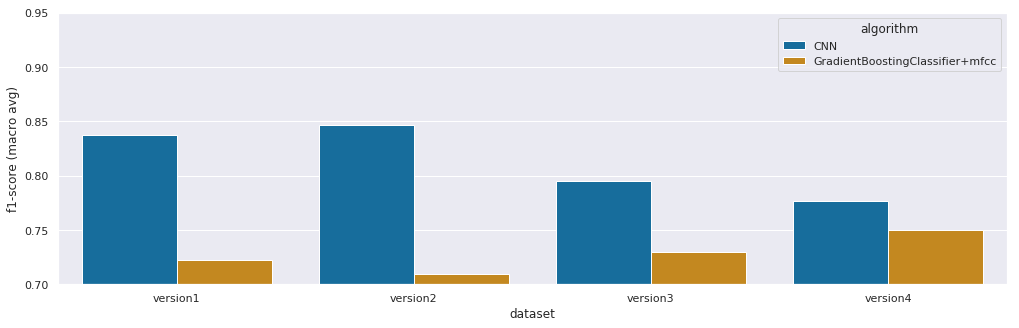

In [26]:
ax = sns.barplot(data=df_result, x="dataset", y='f1-score (macro avg)', hue="algorithm")
ax.set(ylim=(0.70, 0.95))